In [1]:
import pandas as pd
import numpy as np
import pickle
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
%matplotlib inline
# for the model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor 

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as enc

# for feature selection
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures
from feature_engine.selection import RecursiveFeatureAddition


### Loading the Dataset

In [2]:
laptop=pd.read_csv('dataset\laptop_data.csv')

In [3]:
df=laptop.copy()

In [4]:
df.shape

(1303, 12)

### EDA


In [5]:
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


# Dropping Unnamed column

 The Unnamed columns has unique value as same as index which is not adding any information.

In [6]:
df.drop(columns='Unnamed: 0',inplace=True)

# Cleaning Weight Column
The Weight column has dtype has object. Removing Kg from each value in weight column and then converting it into float 

In [7]:
df['Weight'].dtype

dtype('O')

In [8]:
df['Weight']=df['Weight'].str.replace('kg','')
df['Weight']=df['Weight'].astype('float32')

In [9]:
df['Ram']=df['Ram'].str.replace('GB','')
df['Ram']=df['Ram'].astype('int32')

In [10]:
df.head(2)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232


 # Cleaing ScreenResolution
 If we apply Encoding diectlty to the ScreenResoution column then it will create a column with high cardinality. So we will 
 create new columns from ScreenResoution column such as TouchScreen,IPS


In [11]:

df['ScreenResolution'].value_counts()

Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
Touchscreen 2560x1440                              7
4K Ultra HD 3840x2160                              7
IPS Panel 1366x768                                 7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440               

# Touch Screen Column
creating a new column 'Touchscreen' , which indicates whether a laptop has touchscreen or not

In [12]:

df['Touchscreen']=df['ScreenResolution'].apply(lambda x: 'Yes' if 'Touchscreen' in x else 'No')

<AxesSubplot:>

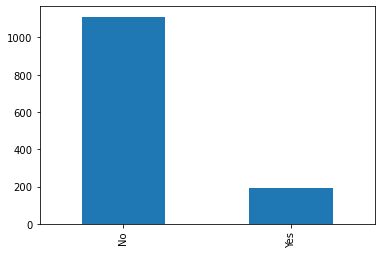

In [13]:
df['Touchscreen'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='Touchscreen', ylabel='Price'>

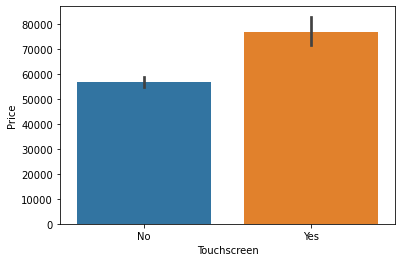

In [14]:
# The laptop with TouchScreen have high prices
sns.barplot(x=df['Touchscreen'],y=df['Price'])

# Ips Columns
creating a new Ips columns from ScreenResolution column

In [15]:
df['Ips'] = df['ScreenResolution'].apply(lambda x:1 if 'Yes' in x else 'No')

In [16]:
df.head(2)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,No,No
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,No,No


<AxesSubplot:>

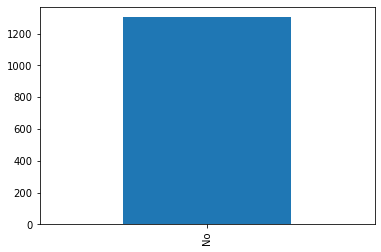

In [17]:
df['Ips'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='Ips', ylabel='Price'>

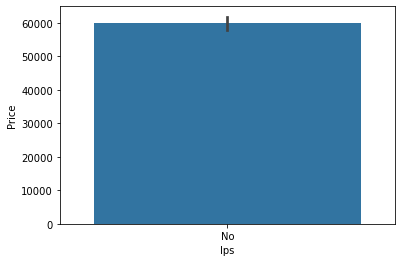

In [18]:
sns.barplot(x=df['Ips'],y=df['Price'])

 Finding Correlation with respect to Price. We can see that there no hig correlation with price column

In [19]:
df.corr()['Price']

Inches    0.068197
Ram       0.743007
Weight    0.210370
Price     1.000000
Name: Price, dtype: float64

### Creating New Column PPI
Here we are creating new column PPI from ScreenResolution.

In [20]:
new = df['ScreenResolution'].str.split('x',n=1,expand=True)

In [21]:
df['X_res'] = new[0]
df['Y_res'] = new[1]


In [22]:
df['X_res'] = df['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x:x[0])

In [23]:
df['X_res'] = df['X_res'].astype('int')
df['Y_res'] = df['Y_res'].astype('int')

In [24]:
df['ppi'] = np.round((((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']),2).astype('float')

In [25]:
df.head(2)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips,X_res,Y_res,ppi
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,No,No,2560,1600,226.98
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,No,No,1440,900,127.68


# Droping ScreenResolution, Inches, X_res,Y_res
With help of ScreenResolution , Inches , X_res,Y_res created a new column PPI
we can see that correlation of ppi column with Price is high. X_res and Y_res has same correltion with price column.
keeping ppi column and dropping the rest.

In [26]:
df.corr()['Price']

Inches    0.068197
Ram       0.743007
Weight    0.210370
Price     1.000000
X_res     0.556529
Y_res     0.552809
ppi       0.473506
Name: Price, dtype: float64

In [27]:
df.drop(columns=['ScreenResolution','Inches','X_res','Y_res'],inplace=True)

### Cleaing CPU Column

The CPU Column has 118 categories. Cannot apply encoding directlty as will it create high cardinality column.

In [28]:
df['Cpu'].value_counts()

Intel Core i5 7200U 2.5GHz              190
Intel Core i7 7700HQ 2.8GHz             146
Intel Core i7 7500U 2.7GHz              134
Intel Core i7 8550U 1.8GHz               73
Intel Core i5 8250U 1.6GHz               72
                                       ... 
Intel Celeron Quad Core N3710 1.6GHz      1
Intel Core i7 2.2GHz                      1
Intel Core i5 2.9GHz                      1
Intel Core i7 2.7GHz                      1
Intel Core M m3 1.2GHz                    1
Name: Cpu, Length: 118, dtype: int64

In [29]:
# 
df['CpuName'] = df['Cpu'].apply(lambda x:" ".join(x.split()[0:3]))
df.head(2)

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips,ppi,CpuName
0,Apple,Ultrabook,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,No,No,226.98,Intel Core i5
1,Apple,Ultrabook,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,No,No,127.68,Intel Core i5


Dividing the CPU column in Intel Core i7 , Intel Core i5, Intel Core i3 , AMD , Other Intel Processor

In [30]:
def fetch_processor(text):
    if text == 'Intel Core i7' or text == 'Intel Core i5' or text == 'Intel Core i3':
        return text
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        else:
            return 'AMD Processor'

In [31]:
df['Cpubrand'] = df['CpuName'].apply(fetch_processor)
df['Cpubrand'].unique()

array(['Intel Core i5', 'Intel Core i7', 'AMD Processor', 'Intel Core i3',
       'Other Intel Processor'], dtype=object)

<AxesSubplot:>

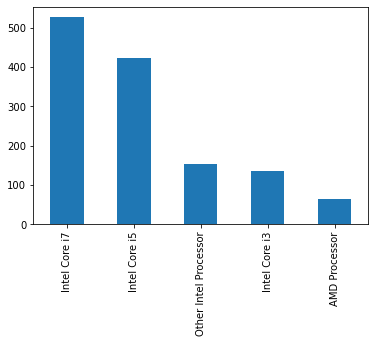

In [32]:
 
df['Cpubrand'].value_counts().plot(kind='bar')

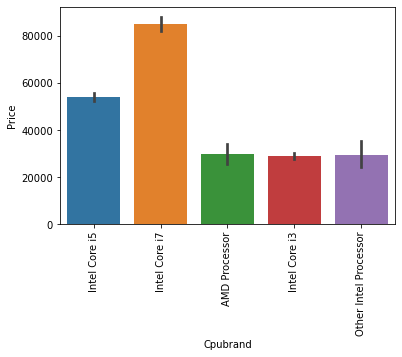

In [33]:
# laptop with Intel Core I7 are most expensive one.
sns.barplot(x=df['Cpubrand'],y=df['Price'])
plt.xticks(rotation='vertical')
plt.show()


Dropping CPU and CPU Name column

In [34]:
df.drop(columns=['Cpu','CpuName'],inplace=True)

In [35]:
df.head()

,Company,TypeName,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips,ppi,Cpubrand
0,Apple,Ultrabook,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,No,No,226.98,Intel Core i5
1,Apple,Ultrabook,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,No,No,127.68,Intel Core i5
2,HP,Notebook,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,No,No,141.21,Intel Core i5
3,Apple,Ultrabook,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,No,No,220.53,Intel Core i7
4,Apple,Ultrabook,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,No,No,226.98,Intel Core i5


### Cleaning Memory Column
Memory Column too have alot of categories with rare label.creating 4 column(HDD	SSD	Hybrid	Flash_Storage) from the memory column

In [36]:
df['Memory'].value_counts()


256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
1TB SSD                           14
512GB SSD +  1TB HDD              14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
16GB SSD                           3
512GB SSD +  2TB HDD               3
128GB SSD +  2TB HDD               2
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
512GB Flash Storage                2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

In [37]:
# Below steps will create 4 new columns. if laptop is with config 1TB HDD and 256 SSD then under HDD column 1000
# and under SSD 256 will be added

df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)
df["Memory"] = df["Memory"].str.replace('GB', '')
df["Memory"] = df["Memory"].str.replace('TB', '000')
new = df["Memory"].str.split("+", n = 1, expand = True)

df["first"]= new[0]
df["first"]=df["first"].str.strip()

df["second"]= new[1]

df["Layer1HDD"] = df["first"].apply(lambda x: 1 if "HDD" in x else 0)
df["Layer1SSD"] = df["first"].apply(lambda x: 1 if "SSD" in x else 0)
df["Layer1Hybrid"] = df["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["Layer1Flash_Storage"] = df["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df['first'] = df['first'].str.replace(r'\D', '')

df["second"].fillna("0", inplace = True)

df["Layer2HDD"] = df["second"].apply(lambda x: 1 if "HDD" in x else 0)
df["Layer2SSD"] = df["second"].apply(lambda x: 1 if "SSD" in x else 0)
df["Layer2Hybrid"] = df["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["Layer2Flash_Storage"] = df["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df['second'] = df['second'].str.replace(r'\D', '')

df["first"] = df["first"].astype(int)
df["second"] = df["second"].astype(int)

df["HDD"]=(df["first"]*df["Layer1HDD"]+df["second"]*df["Layer2HDD"])
df["SSD"]=(df["first"]*df["Layer1SSD"]+df["second"]*df["Layer2SSD"])
df["Hybrid"]=(df["first"]*df["Layer1Hybrid"]+df["second"]*df["Layer2Hybrid"])
df["Flash_Storage"]=(df["first"]*df["Layer1Flash_Storage"]+df["second"]*df["Layer2Flash_Storage"])

# Dropping columns which are not required
df.drop(columns=['first', 'second', 'Layer1HDD', 'Layer1SSD', 'Layer1Hybrid',
       'Layer1Flash_Storage', 'Layer2HDD', 'Layer2SSD', 'Layer2Hybrid',
       'Layer2Flash_Storage'],inplace=True)

In [38]:
df.sample(4)

,Company,TypeName,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips,ppi,Cpubrand,HDD,SSD,Hybrid,Flash_Storage
716,Dell,Notebook,8,256 SSD,Intel HD Graphics 620,Windows 10,1.90,62817.1200,No,No,141.21,Intel Core i5,0,256,0,0
759,Acer,Notebook,4,256 SSD,Intel HD Graphics 620,Windows 10,2.10,31914.7200,No,No,100.45,Intel Core i5,0,256,0,0
1046,HP,Notebook,8,256 SSD,Intel HD Graphics 520,Windows 7,1.43,78268.3200,No,No,157.35,Intel Core i5,0,256,0,0
537,HP,Notebook,4,256 SSD,Intel HD Graphics 405,Windows 10,1.86,21258.1872,No,No,141.21,Other Intel Processor,0,256,0,0


In [39]:
# Dropping the Memory Column
df.drop(columns=['Memory'],inplace=True)

# Cleaning GPU Column
GPU column have 110 categories which is high cardinal. Extracting only the GPU brand name not the version to make it less cardinal

In [40]:
df['Gpu'].value_counts()

Intel HD Graphics 620       281
Intel HD Graphics 520       185
Intel UHD Graphics 620       68
Nvidia GeForce GTX 1050      66
Nvidia GeForce GTX 1060      48
                           ... 
AMD Radeon R7 M465            1
AMD Radeon R5 430             1
AMD Radeon R7 M365X           1
Nvidia GeForce GTX 1070M      1
AMD Radeon Pro 455            1
Name: Gpu, Length: 110, dtype: int64

In [41]:
# From GPU Column selecting the First element of each row which is the GPU brand name
df['Gpubrand'] = df['Gpu'].apply(lambda x:x.split()[0])

In [42]:
df['Gpubrand'].value_counts()

Intel     722
Nvidia    400
AMD       180
ARM         1
Name: Gpubrand, dtype: int64

In [43]:
#As value count of  GPU with ARM brand is only 1 we can remove that row
df = df[df['Gpubrand'] != 'ARM']

In [44]:
df['Gpubrand'].value_counts()

Intel     722
Nvidia    400
AMD       180
Name: Gpubrand, dtype: int64

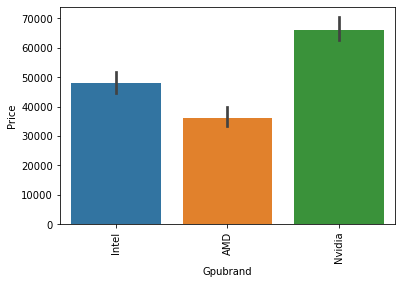

In [45]:
# GPU of Nvidia brand are the most expensive one
sns.barplot(x=df['Gpubrand'],y=df['Price'],estimator=np.median)
plt.xticks(rotation='vertical')
plt.show()

In [46]:
# dropping Gpu column
df.drop(columns=['Gpu'],inplace=True)

# Cleaning the OpSys column


<AxesSubplot:>

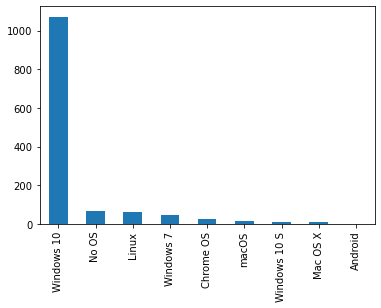

In [47]:
df['OpSys'].value_counts().plot(kind='bar')

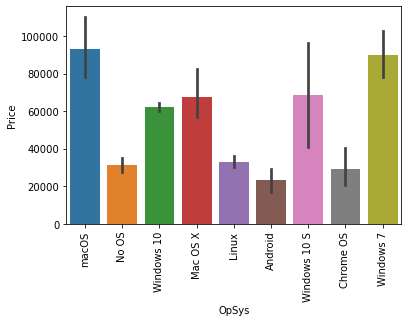

In [48]:
sns.barplot(x=df['OpSys'],y=df['Price'])
plt.xticks(rotation='vertical')
plt.show()

### Dividing the Opsys column categories into Window ,Mac and Other/No Os/Linux

In [49]:
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'

In [50]:
df['os'] = df['OpSys'].apply(cat_os)

In [51]:
df.drop(columns=['OpSys'],inplace=True)

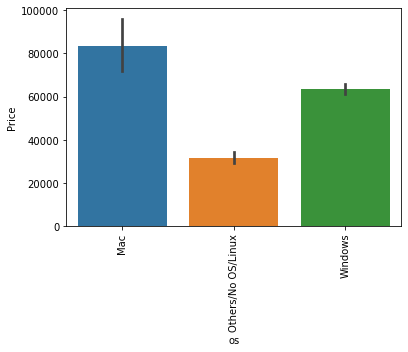

In [52]:
sns.barplot(x=df['os'],y=df['Price'])
plt.xticks(rotation='vertical')
plt.show()

### Droping Hypbrid and Flash_Storage Column
both columns shows negative corr values with Price 

In [53]:
df.corr()['Price']

Ram              0.742905
Weight           0.209867
Price            1.000000
ppi              0.475387
HDD             -0.096891
SSD              0.670660
Hybrid           0.007942
Flash_Storage   -0.040067
Name: Price, dtype: float64

In [54]:
df.drop(columns=['Hybrid','Flash_Storage'],inplace=True)

### Cleaning Price Column
The Price Column is skewed. As we are using linear regression techiques so we convert the price column to noraml disttribution

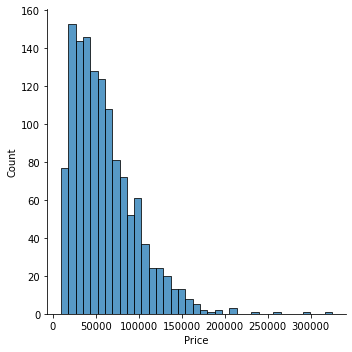

In [55]:

sns.displot(df['Price'])

C:\Users\kanwa\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


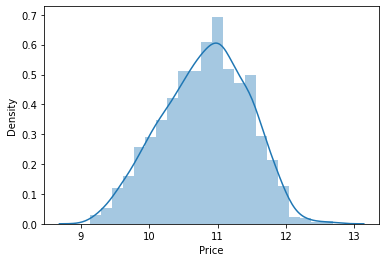

In [56]:
sns.distplot(np.log(df['Price']))
df['Price']=np.log(df['Price'])

### Types of variables 

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1302 non-null   object 
 1   TypeName     1302 non-null   object 
 2   Ram          1302 non-null   int32  
 3   Weight       1302 non-null   float32
 4   Price        1302 non-null   float64
 5   Touchscreen  1302 non-null   object 
 6   Ips          1302 non-null   object 
 7   ppi          1302 non-null   float64
 8   Cpubrand     1302 non-null   object 
 9   HDD          1302 non-null   int64  
 10  SSD          1302 non-null   int64  
 11  Gpubrand     1302 non-null   object 
 12  os           1302 non-null   object 
dtypes: float32(1), float64(2), int32(1), int64(2), object(7)
memory usage: 172.2+ KB


There are a mixture of categorical and numerical variables. Numerical are those of type **int** and **float** and categorical those of type **object**.

#### Find categorical variables

In [58]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables'.format(len(categorical)))
print(categorical)

There are 7 categorical variables
['Company', 'TypeName', 'Touchscreen', 'Ips', 'Cpubrand', 'Gpubrand', 'os']


#### Find discrete variables

In [59]:

# make a list of the numerical variables first
numerical = [var for var in df.columns if df[var].dtype!='O']

discrete = []

for var in numerical:
    if len(df[var].unique()) < 8 :
        print(var, ' values: ', df[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

HDD  values:  [   0  500 1000 2000   32  128]

There are 1 discrete variables


In [60]:
# skiping  the target variable Price which is also numerical and discrete variables

numerical = [var for var in numerical if var not in discrete and var not in [
    'Price']]

print('There are {} numerical and continuous variables'.format(len(numerical)))
print(numerical)

There are 4 numerical and continuous variables
['Ram', 'Weight', 'ppi', 'SSD']


 Now we have inspected and have a view of the different types of variables that we have in the laptop price dataset. Let's move on to understand the types of problems that these variables have.



#### Missing values

In [61]:
# let's output variables with NA and the percentage of NA

for var in df.columns:
    if df[var].isnull().sum() > 0:
        print(var, df[var].isnull().mean())
        
# No missing value we have in or dataset

#### Outliers and distributions

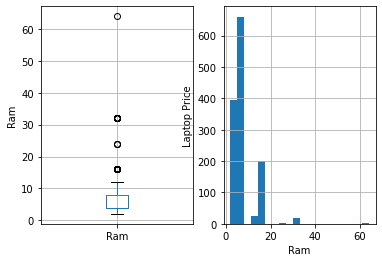

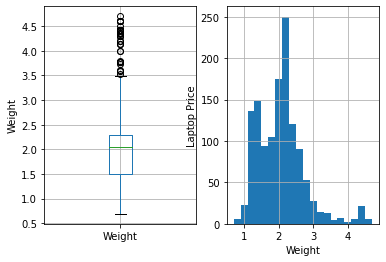

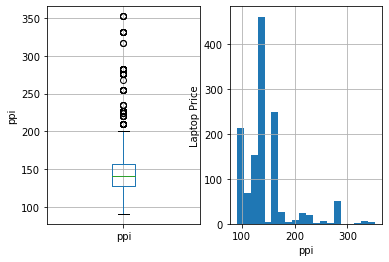

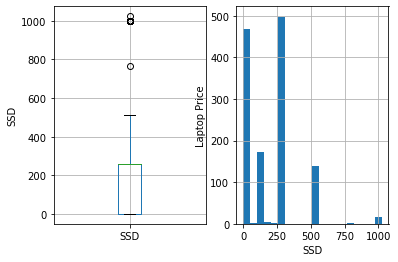

In [62]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('Laptop Price')
    fig.set_xlabel(var)

    plt.show()

#### Outliers in discrete variables

Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % . This is exactly the same as finding rare labels in categorical variables. **Discrete variables can be pre-processed / engineered as if they were categorical**.

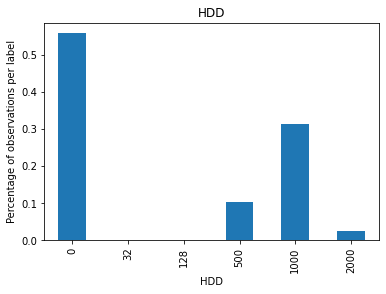

In [63]:
for var in discrete:
    (df.groupby(var)[var].count() / np.float(len(df))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

In Hybrid and Flash_storage columns one of the categoreis having the majority of values.

### Monotonicity between discrete variables and target values

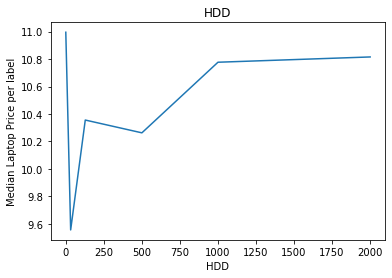

In [64]:
# let's plot the median sale price per value of the discrete
# variable

for var in discrete:
    df.groupby(var)['Price'].median().plot()
    plt.ylabel('Median Laptop Price per label')
    plt.title(var)
    plt.show()

Some of the discrete variables show monotonic relationship and some don't.

#### Number of labels: cardinality

Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

Text(0, 0.5, 'Number of different categories')

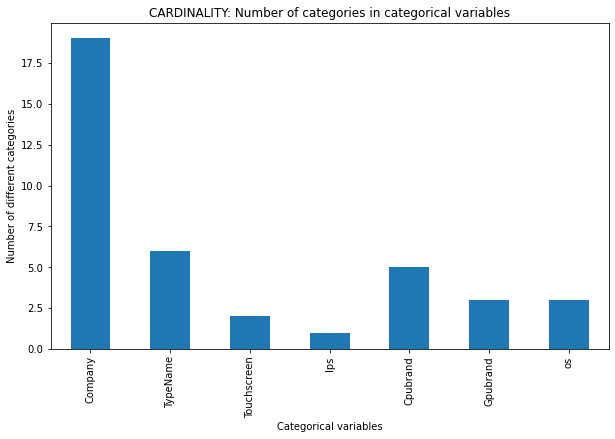

In [65]:
# plot number of categories per categorical variable

df[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

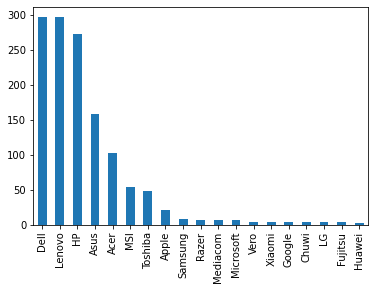

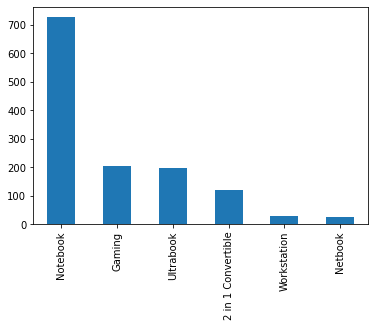

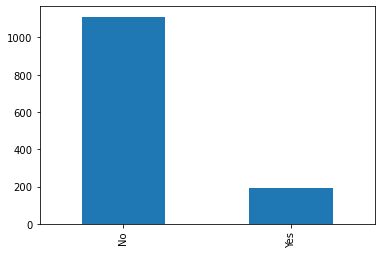

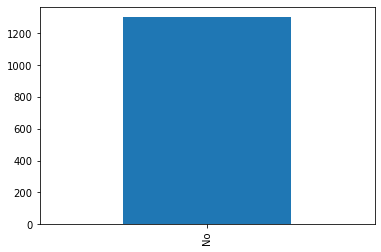

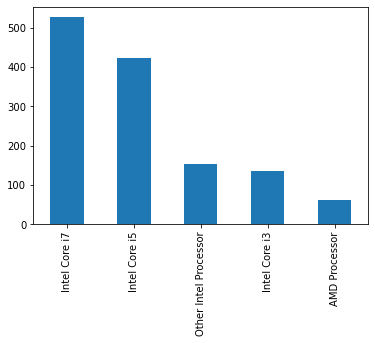

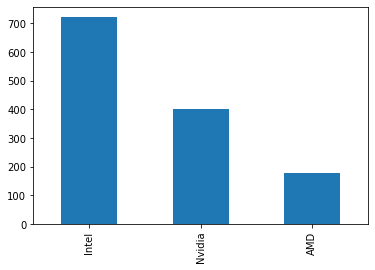

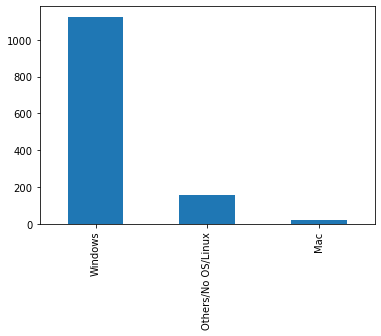

In [66]:
for var in categorical:
    df[var].value_counts().plot(kind='bar')
    plt.show()

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality but we have **rare** labels.

### Separate train and test set

In [67]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Price'], axis=1),
                                                    df['Price'],
                                                    test_size=0.15,
                                                    random_state=0)

X_train.shape, X_test.shape
((1106, 14), (196, 14))

((1106, 14), (196, 14))

### Dumping the Cleaned X_train with Y_train

In [68]:
pickle.dump(X_train,open('X_train.pkl','wb'))
pickle.dump(y_train,open('Y_train.pkl','wb'))

**Now we will move on and engineer the features of this dataset**

### Creating Pipline

In [70]:
preprocessing=Pipeline([
    ('RareLabel_Encoder',enc.RareLabelEncoder(tol=0.05,n_categories=5,variables=categorical )),
    
    ('Ordnal_encoder',enc.OrdinalEncoder(encoding_method='ordered',variables=categorical  ))
    
])

In [71]:
X_train_tf=preprocessing.fit_transform(X_train,y_train)
X_test_tf=preprocessing.transform(X_test)

C:\Users\kanwa\anaconda\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Touchscreen is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\kanwa\anaconda\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Ips is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\kanwa\anaconda\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Cpubrand is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\kanwa\anaconda\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Gpubrand is less than that indicated in n_categories. Thus, all catego

In [73]:
param= {   'n_estimators':[10,20,30,40,50,60,70,75,80],
           'max_depth':[1,2,3,4,5,6],
           'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7],
            'booster': ['gbtree', 'dart'],
             
     }
XGB=XGBRegressor()

In [74]:
gsv=GridSearchCV(estimator=XGB,param_grid=param,cv=2,n_jobs=-1,scoring='r2')
gsv.fit(X_train_tf,y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [75]:
gsv.best_score_

0.8715158866318734

In [76]:
gsv.best_params_

{'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 60}

In [77]:
XGB_model=XGBRegressor(**gsv.best_params_)
XGB_model.fit(X_train_tf,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
y_pred=XGB_model.predict(X_test_tf)

In [83]:
print('Test Score: ',r2_score(y_test,y_pred))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred))


Test Score:  0.8552241224173032
Mean absolute error:  0.17049701529328587
